In [1]:
#回収率を考慮する

# データ取得
import pandas as pd
import time
from tqdm import tqdm_notebook as tqdm

url='https://db.netkeiba.com/race/202106030811/' #年＋場所＋回＋日＋ラウンド
pd.read_html(url)[1]
#複勝の数字が正しく表示されない

,0,1,2,3
0,単勝,7,370,2
1,複勝,7133,170490380,2106
2,枠連,4 - 7,1150,5
3,馬連,7 - 13,4300,16


In [2]:
pd.read_html(url)[2]

,0,1,2,3
0,ワイド,7 - 133 - 73 - 13,154011503560,171245
1,馬単,7 → 13,5510,20
2,三連複,3 - 7 - 13,20000,73
3,三連単,7 → 13 → 3,82320,274


In [3]:
from urllib.request import urlopen

f = urlopen(url)
html = f.read()#バイト型の文字列
html = html.replace(b'<br />', b'br')
pd.read_html(html)[1]

,0,1,2,3
0,単勝,7,370,2
1,複勝,7br13br3,170br490br380,2br10br6
2,枠連,4 - 7,1150,5
3,馬連,7 - 13,4300,16


In [4]:
import time
from tqdm.notebook import tqdm_notebook as tqdm
from urllib.request import urlopen

def scraping_return_tables(id_list):
    return_tables = {}
    for race_id in tqdm(id_list):
        try:
            url='https://db.netkeiba.com/race/' + race_id
            f = urlopen(url)
            html = f.read()#バイト型の文字列
            html = html.replace(b'<br />', b'br')
            dfs = pd.read_html(html)
            return_tables[race_id] = pd.concat([dfs[1], dfs[2]])
            time.sleep(1)
        except IndexError:
            continue
        except:
            break
    return return_tables

In [5]:
result =pd.read_pickle('result_addinfo_p.pickle')
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43239 entries, 202001010101 to 202010020812
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   着順            43239 non-null  int32         
 1   枠番            43239 non-null  int64         
 2   馬番            43239 non-null  int64         
 3   馬名            43239 non-null  object        
 4   斤量            43239 non-null  float64       
 5   騎手            43239 non-null  object        
 6   単勝            43239 non-null  float64       
 7   人気            43239 non-null  float64       
 8   horse_id      43239 non-null  object        
 9   jockey_id     43239 non-null  object        
 10  性             43239 non-null  object        
 11  齢             43239 non-null  int32         
 12  体重            43239 non-null  int32         
 13  体重増減          43239 non-null  int32         
 14  course_len    43239 non-null  object        
 15  weather       43239 non

In [6]:
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train =df.loc[train_id_list]
    test = df.loc[test_id_list]
    train.drop(['date'],axis=1,inplace=True)
    test.drop(['date'],axis=1,inplace=True)
    return train, test

In [7]:
train, test = split_data(result)

In [8]:
race_id_list = test.index.unique()

In [9]:
return_tables = scraping_return_tables(race_id_list)

In [30]:
return_tables

{'202010020706':      0                      1                2          3
 0   単勝                      4             1350          5
 1   複勝               4br12br9    470br160br400    8br2br6
 2   枠連                  2 - 6             2460          7
 3   馬連                 4 - 12             2630          9
 0  ワイド  4 - 12br4 - 9br9 - 12  890br3,800br930  8br39br10
 1   馬単                 4 → 12             6000         24
 2  三連複             4 - 9 - 12            11640         38
 3  三連単             4 → 12 → 9            63930        204,
 '202010020708':      0                      1                  2          3
 0   単勝                     10                280          2
 1   複勝               10br4br1      150br440br310    1br8br5
 2   枠連                  4 - 7               2630         12
 3   馬連                 4 - 10               3030         13
 0  ワイド  4 - 10br1 - 10br1 - 4  1,300br790br3,640  15br9br39
 1   馬単                 10 → 4               4850         16
 2  三連複  

In [31]:
for key in return_tables.keys():
    return_tables[key].index = [key]*len(return_tables[key])
return_tables_pd = pd.concat([return_tables[key] for key in return_tables.keys()],sort=False)

In [34]:
return_tables_pd.to_pickle('return_tables.pickle')

In [10]:
# return_tables_pd= pd.read_pickle('return_tables.pickle')

In [11]:
return_tables_pd.head()

,0,1,2,3
202010020706,単勝,4,1350,5
202010020706,複勝,4br12br9,470br160br400,8br2br6
202010020706,枠連,2 - 6,2460,7
202010020706,馬連,4 - 12,2630,9
202010020706,ワイド,4 - 12br4 - 9br9 - 12,"890br3,800br930",8br39br10


In [39]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
        
    #複勝行の加工 
    @property
    def fuku(self):
        fuku = self.return_tables[self.return_tables[0] == '複勝'][[1,2]]
        #勝ち馬の馬番
        wins = fuku[1].str.split('br', expand = True).drop([3,4], axis=1)
        wins.columns = ['win_0', 'win_1', 'win_2']
        #払い戻し
        returns = fuku[2].str.split('br', expand = True).drop([3,4], axis=1)
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        return df.fillna(0).astype(int)

In [40]:
rt = Return(return_tables_pd)

In [42]:
rt.fuku.info()

<class 'pandas.core.frame.DataFrame'>
Index: 936 entries, 202010020706 to 202006050804
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   win_0     936 non-null    int32
 1   win_1     936 non-null    int32
 2   win_2     936 non-null    int32
 3   return_0  936 non-null    int32
 4   return_1  936 non-null    int32
 5   return_2  936 non-null    int32
dtypes: int32(6)
memory usage: 29.2+ KB


In [43]:
horse_results = pd.read_pickle('horse_data.pickle')
horse_results.head()

,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,オッズ,...,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金,受賞歴
2018101626,2021/04/11,3中山6,晴,7.0,3歳1勝クラス,NaN,10.0,1.0,1.0,52.9,...,**,5-6-6-5,38.0-34.7,34.6,450(+2),NaN,NaN,ミヤビハイディ,NaN,NaN
2018101626,2021/03/27,3中山1,晴,6.0,3歳1勝クラス,NaN,8.0,8.0,8.0,72.1,...,**,8-8-8-8,36.3-36.6,36.3,448(+4),NaN,NaN,スペシャルドラマ,NaN,NaN
2018101626,2021/03/13,2中山5,雨,7.0,3歳1勝クラス,NaN,11.0,6.0,7.0,99.2,...,**,9-9-7-8,37.5-38.2,40.5,444(0),NaN,NaN,ヴァイスメテオール,NaN,NaN
2018101626,2020/10/03,4中山8,曇,9.0,芙蓉S(OP),NaN,9.0,1.0,1.0,35.0,...,**,7-7-9-9,36.2-35.5,36.2,444(+8),NaN,NaN,ランドオブリバティ,NaN,NaN
2018101626,2020/09/05,2札幌7,晴,11.0,札幌2歳S(G3),NaN,14.0,6.0,9.0,10.7,...,**,6-6-5-10,35.0-36.9,37.8,436(-2),NaN,NaN,ソダシ,NaN,NaN


In [44]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','R','賞金']]
        self.preprocessing()
        
        
    def preprocessing(self): #特に引数がない場合はselfのみ
        result = self.horse_results.copy()
        #着順の0-9以外の文字を含むデータを除く
        #result = result[-result["R"].astype(str).str.contains("\D")] 
        result["着順"] = result["R"].astype(float)
        result["賞金"].fillna(0, inplace=True)
        result["賞金"] = result["賞金"].astype(float)
        result["日付"] = pd.to_datetime(result["日付"])
        result.drop(["R"],axis=1, inplace=True)
        
        self.horse_results = result
        
    def average(self, horse_id_list, date, n_samples='all'):
        self.horse_results.rename(columns={'着順':'着順_ave','賞金':'賞金_ave'}, inplace=True)
        target_df = self.horse_results.loc[horse_id_list]
        #平均する対象をレース日付以前のうち直近n_samplesのデータのみに限定する（古いデータを反映させないため）
        if n_samples=='all':
            filtered_df = target_df[target_df['日付'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['日付'] < date].\
                sort_values('日付',ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        return filtered_df.groupby(level=0)[['着順_ave','賞金_ave']].mean()
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        #レース結果の同じ日付のかたまりごとに1行ずつhorse_idにひもづくその日付以前の戦績の平均を算出し（average）、
        # レース結果のかたまりにマージする(merge)という意味
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)]) 
        return merged_df

In [45]:
hr = HorseResults(horse_results)
results_5R = hr.merge_all(result, 5)
results_5R.head()

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,horse_id,jockey_id,...,齢,体重,体重増減,course_len,weather,race_type,ground_state,date,着順_ave,賞金_ave
202001010101,1,6,6,ウインルーア,54.0,横山武史,16.0,3.0,2018101626,01170,...,2,438,4,1800,曇,芝,良,2020-07-25,6.0,0.0
202001010101,2,2,2,アークライト,54.0,ルメール,1.9,2.0,2018105193,05339,...,2,510,0,1800,曇,芝,良,2020-07-25,5.0,280.0
202001010101,3,3,3,ギャラントウォリア,54.0,池添謙一,1.8,1.0,2018104800,01032,...,2,482,-6,1800,曇,芝,良,2020-07-25,5.0,280.0
202001010101,4,1,1,ジュンブーケ,52.0,亀田温心,22.2,4.0,2018102410,01176,...,2,442,0,1800,曇,芝,良,2020-07-25,5.0,70.0
202001010101,5,4,4,キタノマンゲツ,54.0,藤岡康太,55.7,5.0,2018100828,01116,...,2,426,-8,1800,曇,芝,良,2020-07-25,5.0,0.0


In [46]:
results_5R['rank'] = results_5R['着順'].map(lambda x : 1 if x<4 else 0)
results_5R.drop(['着順','馬名','騎手'],axis=1, inplace=True)

In [47]:
results_5R.drop(['horse_id'],axis=1, inplace=True)
results_5R.head()

,枠番,馬番,斤量,単勝,人気,jockey_id,性,齢,体重,体重増減,course_len,weather,race_type,ground_state,date,着順_ave,賞金_ave,rank
202001010101,6,6,54.0,16.0,3.0,01170,牝,2,438,4,1800,曇,芝,良,2020-07-25,6.0,0.0,1
202001010101,2,2,54.0,1.9,2.0,05339,牡,2,510,0,1800,曇,芝,良,2020-07-25,5.0,280.0,1
202001010101,3,3,54.0,1.8,1.0,01032,牡,2,482,-6,1800,曇,芝,良,2020-07-25,5.0,280.0,1
202001010101,1,1,52.0,22.2,4.0,01176,牝,2,442,0,1800,曇,芝,良,2020-07-25,5.0,70.0,0
202001010101,4,4,54.0,55.7,5.0,01116,牡,2,426,-8,1800,曇,芝,良,2020-07-25,5.0,0.0,0


In [48]:
results_d = pd.get_dummies(results_5R)
train, test = split_data(results_d)
X_train = train.drop(['rank'],axis=1)
y_train = train['rank']
X_test = test.drop(['rank'],axis=1)
y_test = test['rank']

In [49]:
X_train.head()

,枠番,馬番,斤量,単勝,人気,齢,体重,体重増減,着順_ave,賞金_ave,...,weather_曇,weather_雨,weather_雪,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重
202006010101,4,7,54.0,3.6,2.0,3,460,2,3.0,280.0,...,0,0,0,1,0,0,0,0,1,0
202006010101,1,1,54.0,17.2,5.0,3,432,4,6.0,180.0,...,0,0,0,1,0,0,0,0,1,0
202006010101,2,3,54.0,199.0,12.0,3,458,0,3.5,0.0,...,0,0,0,1,0,0,0,0,1,0
202006010101,3,6,54.0,50.4,8.0,3,418,0,2.2,10.0,...,0,0,0,1,0,0,0,0,1,0
202006010101,6,12,54.0,1.6,1.0,3,536,-2,3.0,240.0,...,0,0,0,1,0,0,0,0,1,0


In [50]:
#勾配ブースティング木
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score

params = {
    'num_leaves':3, #デフォルトは34
    'n_estimators':70,
    'min_data_in_leaf':300,
#     'class_weight':'balanced',
    'random_state':100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values) #値に日本語が入っているとエラー

y_pred_train = lgb_clf.predict_proba(X_train)[:,1]
print(roc_auc_score(y_train, y_pred_train))
y_pred = lgb_clf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
0.806535986960768
0.810319429089434


In [51]:
importances = pd.DataFrame({'features': X_train.columns, 'importance': lgb_clf.feature_importances_})
importances.sort_values('importance', ascending=False)[:20]

,features,importance
3,単勝,96
4,人気,13
9,賞金_ave,13
2,斤量,5
6,体重,5
8,着順_ave,5
0,枠番,2
7,体重増減,1
163,jockey_id_05429,0
168,jockey_id_05517,0


In [52]:
#modelを評価するクラスを作成
from sklearn.metrics import roc_auc_score

class ModelEvaluator:
    def __init__(self, model, return_table):
        self.model = model
        self.fuku = Return(return_table).fuku
        
    def predict_proba(self, X):
        return self.model.predict_proba(X)[:,1]
    
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
        
    def calc_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        money = -100*len(pred_table)
        df = self.fuku.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money +=df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return money

In [55]:
me = ModelEvaluator(lgb_clf, return_tables_pd)
me.predict_proba(X_train)

array([0.53883799, 0.2216029 , 0.01329923, ..., 0.41010456, 0.01287468,
       0.01260946])

In [56]:
me.score(y_train, X_train)

0.806535986960768

In [57]:
me.score(y_test, X_test)

0.810319429089434

In [58]:
me.feature_importance(X_train).head()

,features,importance
3,単勝,96
4,人気,13
9,賞金_ave,13
2,斤量,5
6,体重,5


In [61]:
me = ModelEvaluator(lgb_clf, return_tables_pd)
me.calc_return(X_test)

-22310.0

In [62]:
gain = {}
n_samples = 100
for i in tqdm((range(n_samples))):
    threshold = i/n_samples
    gain[threshold] = me.calc_return(X_test, threshold)

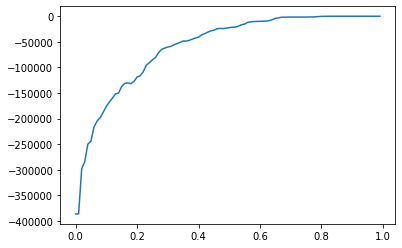

In [63]:
pd.Series(gain).plot()

In [64]:
me.fuku

,win_0,win_1,win_2,return_0,return_1,return_2
202010020706,4,12,9,470,160,400
202010020708,10,4,1,150,440,310
202010020709,3,12,6,120,140,470
202010020707,3,11,15,170,170,680
202010020711,12,16,7,610,410,1160
...,...,...,...,...,...,...
202006050805,12,13,15,250,110,1060
202006050801,9,16,8,220,180,140
202006050802,12,6,10,300,150,590
202006050803,1,3,10,120,230,200
